In [ ]:
from typing import Tuple, List, Callable, Set, Any
from urllib.parse import urlparse

In [ ]:
def http_program(url: str) -> bool:
    supported_schemes = ["http", "https"]
    result = urlparse(url)
    if result.scheme not in supported_schemes:
        raise ValueError("Scheme must be one of" + repr(supported_schemes))

    if result.netloc == "":
        raise ValueError("Host must be non-empty")

    return True

In [ ]:
from fuzzingbook.Fuzzer import fuzzer

fuzzer(char_start=32, char_range=96)

'n7$3nt/FN);>2Bkl?G*}D,h"b@cVB4+4w4KNgbqp%bti b~NXT0]>@WzX[%\\g\'n,]l,c'

In [4]:
for i in range(1000):
    try:
        url = fuzzer()
        result = http_program(url)
    except ValueError:
        pass

In [ ]:
import random


def delete_random_character(s: str) -> str:
    if s == "":
        return s
    pos = random.randint(0, len(s) - 1)

    return s[:pos] + s[pos + 1 :]


seed_input = "A quick brown fox"
for i in range(10):
    x = delete_random_character(seed_input)
    print(repr(x))

'A quick brownfox'
'Aquick brown fox'
'A quck brown fox'
' quick brown fox'
'A uick brown fox'
'A quic brown fox'
'A uick brown fox'
'Aquick brown fox'
'A quick brown fx'
' quick brown fox'


In [ ]:
def insert_random_character(s: str) -> str:
    pos = random.randint(0, len(s))
    random_character = chr(random.randrange(32, 127))
    return s[:pos] + random_character + s[pos:]


for i in range(10):
    print(repr(insert_random_character(seed_input)))

'A quick sbrown fox'
'A q]uick brown fox'
'A quick brown fox4'
'AJ quick brown fox'
'A quick brown fogx'
'A qu ick brown fox'
'A quic,k brown fox'
'A quick brown f@ox'
'A quick bro9wn fox'
'+A quick brown fox'


In [ ]:
def flip_random_character(s):
    if s == "":
        return s

    pos = random.randint(0, len(s) - 1)
    c = s[pos]
    bit = 1 << random.randint(0, 6)
    new_c = chr(ord(c) ^ bit)

    return s[:pos] + new_c + s[pos + 1 :]


for i in range(10):
    print(repr(flip_random_character(seed_input)))

'A quici brown fox'
'A q}ick brown fox'
'A quick(brown fox'
'A quick brown foh'
'A quick brown fkx'
'A quick brown foz'
'A quick brgwn fox'
'A`quick brown fox'
'A quic{ brown fox'
'A qUick brown fox'


In [ ]:
def mutate(s: str) -> str:
    mutators = [
        delete_random_character,
        insert_random_character,
        flip_random_character,
    ]

    mutator = random.choice(mutators)

    return mutator(s)


for _ in range(10):
    print(repr(mutate(seed_input)))

'A quick brow fox'
'A quick brown f}ox'
'A quick brown dox'
'.A quick brown fox'
'A quick brown ox'
'HA quick brown fox'
'A quick brown fo'
'A quick brvown fox'
'A quick brown fowx'
'Q quick brown fox'


In [ ]:
def is_valid_url(url: str) -> bool:
    try:
        result = http_program(url)
        return True
    except ValueError:
        return False


assert is_valid_url("http://www.google.com/search?q=fuzzing")
assert not is_valid_url("xyzzy")

In [16]:
seed_input = "http://www.google.com/search?q=fuzzing"
valid_inputs = set()
trials = 20

for _ in range(trials):
    inp = mutate(seed_input)
    if is_valid_url(inp):
        valid_inputs.add(inp)

In [ ]:
len(valid_inputs) / trials

0.85

In [20]:
trials = 3 * 96 * len(seed_input)
trials

10944

In [ ]:
from fuzzingbook.Timer import Timer

trials = 0
with Timer() as t:
    while True:
        trials += 1
        inp = mutate(seed_input)
        if inp.startswith("https://"):
            print("Success after", trials, "trials in", t.elapsed_time(), "seconds")
            break

Success after 6673 trials in 0.013740928999823154 seconds


In [22]:
seed_input = "http://www.google.com/search?q=fuzzing"
mutations = 50

inp = seed_input
for i in range(mutations):
    if i % 5 == 0:
        print(i, "mutations:", repr(inp))
    inp = mutate(inp)

0 mutations: 'http://www.google.com/search?q=fuzzing'
5 mutations: 'http://www.google.com/seargheq=fuzzin'
10 mutations: 'htt?p:/o7ww.googl.com/seargheqfuzzin'
15 mutations: 'htt?p:/osww.googl.com/%seargheq uzzin'
20 mutations: 'htu?p:/osww.googlcom/%searghq uzxn'
25 mutations: 'huu?p:/oswv.gmoglcom/searghq uz?xn'
30 mutations: 'huu?p:/ols7v.gmoqglcZom/searghq uz?xn'
35 mutations: 'huu?p:/ols7v.gmopglcXom/seargh^q fBuz?xn'
40 mutations: 'huu?p:/o6s7P6.gmopglcXom/seargh^ fBuz?xn'
45 mutations: 'huu?p:/k6s7P6gmopglcXom?searj^ fBuz?xn'


In [ ]:
from fuzzingbook.Fuzzer import Fuzzer


class MutationFuzzer(Fuzzer):
    def __init__(
        self, seed: List[str], min_mutations: int = 2, max_mutations: int = 10
    ) -> None:
        self.seed = seed
        self.min_mutations = min_mutations
        self.max_mutations = max_mutations
        self.reset()

    def reset(self) -> None:
        self.population = self.seed
        self.seed_index = 0

In [ ]:
class MutationFuzzer(MutationFuzzer):
    def mutate(self, inp: str) -> str:
        return mutate(inp)


class MutationFuzzer(MutationFuzzer):
    def create_candidate(self) -> str:
        candidate = random.choice(self.population)
        trials = random.randint(self.min_mutations, self.max_mutations)

        for _ in range(trials):
            candidate = self.mutate(candidate)
        return candidate


class MutationFuzzer(MutationFuzzer):
    def fuzz(self) -> str:
        if self.seed_index < len(self.seed):
            self.inp = self.seed[self.seed_index]
            self.seed_index += 1
        else:
            self.inp = self.create_candidate()
        return self.inp

In [25]:
seed_input = "http://www.google.com/search?q=fuzzing"
mutation_fuzzer = MutationFuzzer(seed=[seed_input])
mutation_fuzzer.fuzz()

'http://www.google.com/search?q=fuzzing'

In [26]:
print(mutation_fuzzer.fuzz())
print(mutation_fuzzer.fuzz())

http:'/wwwgoogle.com/sEarch?qfuzing
http://ww.gogle.ceom/earch?q=fuzzing


In [ ]:
from fuzzingbook.Fuzzer import Runner


class FunctionRunner(Runner):
    def __init__(self, function: Callable) -> None:
        self.function = function

    def run_function(self, inp: str) -> Any:
        return self.function(inp)

    def run(self, inp: str) -> Tuple[Any, str]:
        try:
            result = self.run_function(inp)
            outcome = self.PASS
        except Exception:
            result = None
            outcome = self.FAIL

        return result, outcome


http_runner = FunctionRunner(http_program)
http_runner.run("https://foo.bar")

(True, 'PASS')

In [ ]:
from fuzzingbook.Coverage import Coverage, population_coverage, Location

In [ ]:
class FunctionCoverageRunner(FunctionRunner):
    def run_function(self, inp: str) -> Any:
        with Coverage() as cov:
            try:
                result = super().run_function(inp)
            except Exception as exc:
                self._coverage = cov.coverage()
                raise exc
        self._coverage = cov.coverage()
        return result

    def coverage(self) -> Set[Location]:
        return self._coverage


http_runner = FunctionCoverageRunner(http_program)
http_runner.run("https://foo.bar/")

print(list(http_runner.coverage())[:5])

[('urlparse', 396), ('urlparse', 402), ('_coerce_args', 125), ('_coerce_args', 131), ('http_program', 3)]


In [ ]:
class MutationCoverageFuzzer(MutationFuzzer):
    def reset(self) -> None:
        super().reset()
        self.coverages_seen: Set[frozenset] = set()
        self.population = []

    def run(self, runner: FunctionCoverageRunner) -> Any:
        result, outcome = super().run(runner)
        new_coverage = frozenset(runner.coverage())
        if outcome == Runner.PASS and new_coverage not in self.coverages_seen:
            self.population.append(self.inp)
            self.coverages_seen.add(new_coverage)

        return result

In [35]:
seed_input = "http://www.google.com/search?q=fuzzing"
mutation_fuzzer = MutationCoverageFuzzer(seed=[seed_input])
mutation_fuzzer.runs(http_runner, trials=10000)
mutation_fuzzer.population

['http://www.google.com/search?q=fuzzing',
 'http://www#.google*com/search?q=fuzzing',
 'http://wcww.google.com/search?q=fuJzzinc',
 'http://wcww.googleN.comM/searchq=buJzzinc',
 'http://wcwwgoogleN.cooMsearchq=buJzz4inc',
 'http://wcww.Cgoogle.com/{;eerch?q=fuJzzinc',
 'http://wcww.Cgogjle.com/{;eerch;q=fuJzzinc',
 'http://cwv.CgoGgjle.com/{;eerch;q=f/uJzzinc',
 'http://wcww.goVC\x7fgle.Ycom/search?q=fuJzzin#',
 'http://av.CgoGjleR.com/{;eech;u#=d/uJzz7in[c',
 'http://av.goEjlWeR>com/{;:%ech?u#5d/ujzzS7in[c',
 'http://wcw7.Cgogle3com/{=;egr/ch?=fuJzzinc',
 'http://av.oEjlWeR.gom/{;%Ech/u#5d/ujzzgS\x17in[c',
 "htTp://wkwD7.Crg'le3coNm/{=;egr/ch?=fUuJzjin#"]

Text(0, 0.5, 'lines covered')

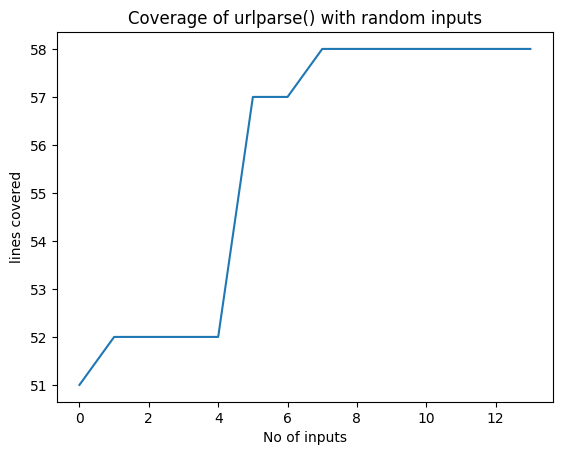

In [ ]:
all_coverage, cumulative_coverage = population_coverage(
    mutation_fuzzer.population, http_program
)

import matplotlib.pyplot as plt

plt.plot(cumulative_coverage)
plt.title("Coverage of urlparse() with random inputs")
plt.xlabel("No of inputs")
plt.ylabel("lines covered")

In [ ]:
from fuzzingbook.Coverage import cgi_decode

seed = ["Hello world"]
cgi_runner = FunctionCoverageRunner(cgi_decode)
m = MutationCoverageFuzzer(seed)
results = m.runs(cgi_runner, 10000)

In [50]:
m.population

['Hello world', 'Hel `wv+ld', '\x08%eELmo worl', '%eEL-So+ wo2,']

In [51]:
cgi_runner.coverage()

{('cgi_decode', 207),
 ('cgi_decode', 208),
 ('cgi_decode', 209),
 ('cgi_decode', 210),
 ('cgi_decode', 211),
 ('cgi_decode', 214),
 ('cgi_decode', 215),
 ('cgi_decode', 216),
 ('cgi_decode', 217),
 ('cgi_decode', 218),
 ('cgi_decode', 220),
 ('cgi_decode', 229),
 ('cgi_decode', 230),
 ('cgi_decode', 231),
 ('run_function', 8)}

In [ ]:
all_coverage, cumulative_coverage = population_coverage(m.population, cgi_decode)

Text(0, 0.5, 'lines covered')

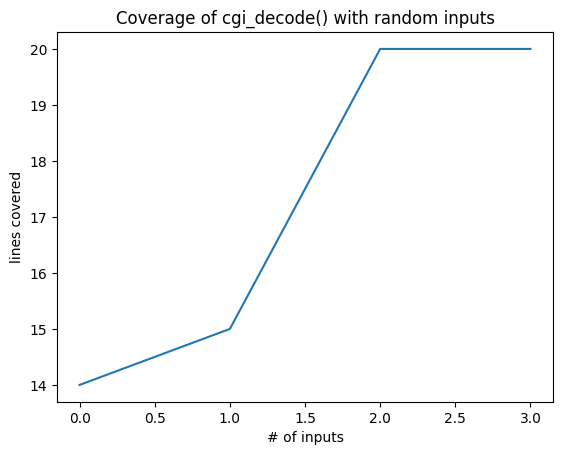

In [ ]:
plt.plot(cumulative_coverage)
plt.title("Coverage of cgi_decode() with random inputs")
plt.xlabel("# of inputs")
plt.ylabel("lines covered")

In [ ]:
from fuzzingbook.Fuzzer import ProgramRunner

seed = ["1 + 1"]
bc = ProgramRunner(program="bc")
m = MutationFuzzer(seed)
outcomes = m.runs(bc, trials=100)

In [60]:
outcomes[:3]

[(CompletedProcess(args='bc', returncode=0, stdout='', stderr='(standard_in) 1: syntax error\n'),
  'PASS'),
 (CompletedProcess(args='bc', returncode=0, stdout='', stderr='(standard_in) 1: syntax error\n'),
  'PASS'),
 (CompletedProcess(args='bc', returncode=0, stdout='', stderr='(standard_in) 1: illegal character: `\n(standard_in) 1: syntax error\n'),
  'PASS')]

In [ ]:
sum(1 for completed_process, outcome in outcomes if completed_process == "")

0